In [2]:
%matplotlib inline
import urllib
import os
import openpyxl as px
import zipfile
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from sklearn import linear_model
from sklearn import tree
from sklearn.cross_validation import train_test_split

from __future__ import division


In [3]:
urls = ["https://resources.lendingclub.com/LoanStats3a.csv.zip",
       "https://resources.lendingclub.com/LoanStats3b.csv.zip",
        "https://resources.lendingclub.com/LoanStats3c.csv.zip",
        "https://resources.lendingclub.com/LoanStats3d.csv.zip"]

data_dict_url = "https://resources.lendingclub.com/LCDataDictionary.xlsx"

def download(url, unzip=False):
    file_name = url.split("/")[-1]
    if os.path.isfile(file_name):
        print "%s already downloaded" % file_name
    else:    
        print "Downloading %s..." % file_name
        urllib.urlretrieve(url, file_name)
        print "%s downloaded" % file_name

    if unzip:
        file_type = file_name.split(".")[-1]
        if file_type.lower() == "zip":
            z = zipfile.ZipFile(file_name)
            extracted = []
            for f in z.namelist():
                extracted.append(f)
                if os.path.isfile(f):
                    print "%s already unzipped" % f
                else:
                    z.extract(f)
                    print "Unzipped %s" % f
            return extracted
    return file_name

headers_file = download(data_dict_url)
headers_ws = px.load_workbook(headers_file, read_only=True).get_active_sheet()

data_files = []

for url in urls:
    data_file = download(url, unzip=True)
    data_files.extend(data_file)

LCDataDictionary.xlsx already downloaded
LoanStats3a.csv.zip already downloaded
LoanStats3a.csv already unzipped
LoanStats3b.csv.zip already downloaded
LoanStats3b.csv already unzipped
LoanStats3c.csv.zip already downloaded
LoanStats3c.csv already unzipped
LoanStats3d.csv.zip already downloaded
LoanStats3d.csv already unzipped


In [4]:
# Deal with the headers

# Dispense of header of headers
headers_ws.rows.next()

headers = []
headers_desc = {}
for row in headers_ws.rows:
    header, desc = map(lambda x: x.value, row[:2])
    if header is not None:
        headers.append(header)
        headers_desc[header] = desc

In [5]:
# Load the data
df = pd.DataFrame()
for data_file in data_files:
    with open(data_file,'rb') as f:
        reader = csv.reader(f)
        # remove disclaimer
        reader.next()
        
        header_row = 1
        end_row = 1
        while len(reader.next()) > 1:
            end_row += 1
        print "Loading %s" % data_file
        df = df.append(pd.read_csv(data_file, header=header_row, nrows=end_row))
        print "Finished loading %s" % data_file

print "Finished loading data."

Loading LoanStats3a.csv
Finished loading LoanStats3a.csv
Loading LoanStats3b.csv
Finished loading LoanStats3b.csv
Loading LoanStats3c.csv

/Users/branko/Library/Python/2.7/lib/python/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/branko/Library/Python/2.7/lib/python/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Finished loading LoanStats3c.csv
Loading LoanStats3d.csv
Finished loading LoanStats3d.csv
Finished loading data.


/Users/branko/Library/Python/2.7/lib/python/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
def mdiff(start, end):
    """ Difference between two dates in months """
    return ((end.year - start.year) * 12) + (end.month - start.month) 

In [7]:
# Filter out missing issue and payment dates
df = df[df.issue_d.notnull() & df.last_pymnt_d.notnull() & df.term.notnull()]

# Convert dates to datetime
df.issue_d = pd.to_datetime(df.issue_d)
df.last_pymnt_d = pd.to_datetime(df.last_pymnt_d)
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

# Add maturity
df.term = df.term.str.replace(" months","").astype(int)
months = map(lambda x: pd.offsets.MonthBegin(x + 1,'M'), df.term)
df.maturity =  pd.Series(df.issue_d + np.array(months))

# Convert interest rates to float
df.int_rate = pd.Series(df.int_rate).str.replace('%', '').astype(float)
df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

# Convert employment length to number
df.emp_length.replace(to_replace='n/a', value=np.nan, inplace=True)
df.emp_length.fillna(value=0, inplace=True)
df.emp_length.replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emp_length = df.emp_length.astype(int)

# Convert earliest credit line field to months
df['credit_history'] = pd.Series(
    [mdiff(start,end) for start, end in zip(df.earliest_cr_line, df.issue_d)], index=df.index)


/Library/Python/2.7/site-packages/pandas/core/ops.py:477: PerformanceWarning: Adding/subtracting array of DateOffsets to Series not vectorized
  "Series not vectorized", PerformanceWarning)


Loan count grew drastically in the later years while the loan size grew slightly


/Library/Python/2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history
count,8.839710e+05,883971.000000,883971.000000,883971.000000,883971.000000,883971.000000,883971.000000,883971.000000,8.839710e+05,883971.000000,...,816545.000000,816392.000000,828467.000000,883274.000000,883932.000000,8.165450e+05,8.367760e+05,8.367760e+05,8.165450e+05,883971.000000
mean,3.511063e+07,14774.596735,14761.789414,14730.531165,43.215495,13.241600,437.196483,5.789822,7.504544e+04,18.170081,...,2.048087,94.304594,49.744465,0.119373,0.048581,1.709788e+05,4.913403e+04,2.104784e+04,4.066068e+04,196.314565
std,2.407235e+07,8434.627386,8428.976184,8435.121162,11.004937,4.384864,244.130523,3.695795,6.469668e+04,17.215595,...,1.727832,8.501970,35.412858,0.359431,0.389245,1.730299e+05,4.655770e+04,2.079958e+04,4.206248e+04,89.526504
min,7.069900e+04,500.000000,500.000000,0.000000,36.000000,5.320000,15.690000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,36.000000
25%,1.103958e+07,8000.000000,8000.000000,8000.000000,36.000000,9.990000,261.150000,2.000000,4.500000e+04,11.920000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.000000
50%,3.714757e+07,13000.000000,13000.000000,13000.000000,36.000000,12.990000,382.550000,6.000000,6.500000e+04,17.670000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.000000
75%,5.856886e+07,20000.000000,20000.000000,20000.000000,60.000000,16.200000,573.060000,10.000000,9.000000e+04,23.960000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.000000
max,7.354484e+07,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1445.460000,10.000000,9.500000e+06,9999.000000,...,30.000000,100.000000,100.000000,12.000000,85.000000,9.999999e+06,2.921551e+06,1.090700e+06,2.101913e+06,852.000000


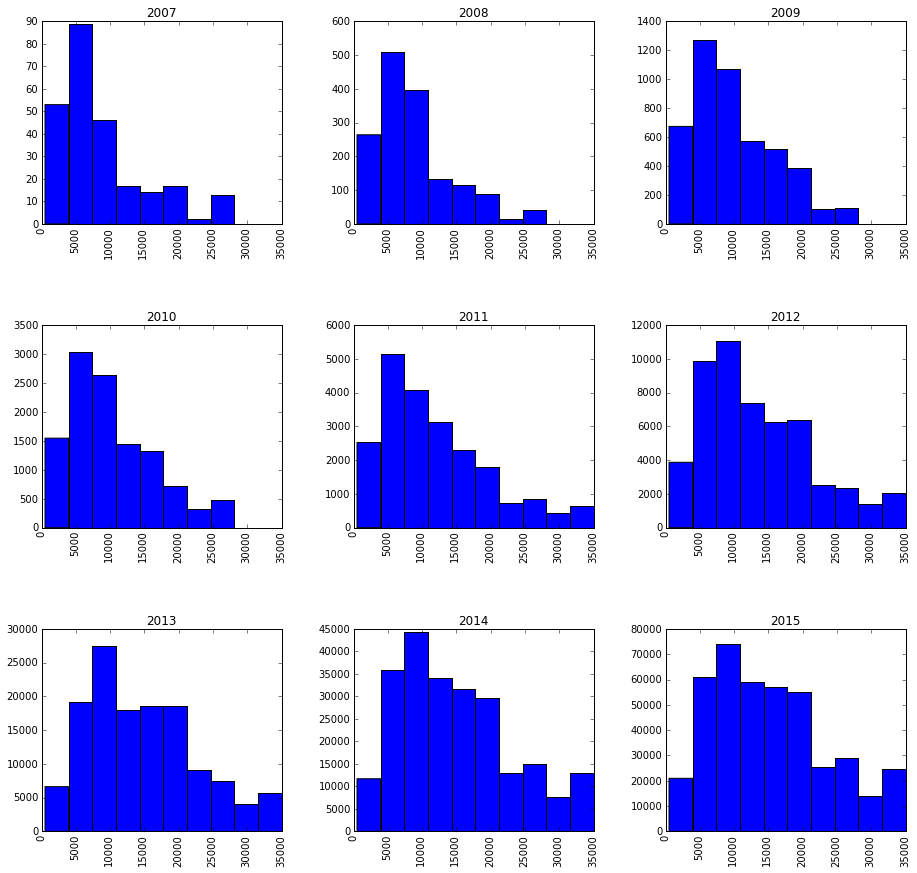

In [8]:
# Let's take a look at the data
print "Loan count grew drastically in the later years while the loan size grew slightly"
df.funded_amnt.hist(by=df.issue_d.dt.year, range=(df.funded_amnt.min(), df.funded_amnt.max()), figsize=(15,15))
df.describe()

14.59% of loans are taking some sort of charge off 
7.60% of principal is not being repaid 
Of those taking some kind of charge-off, the severity is 50.93%


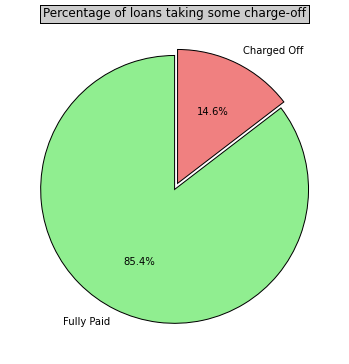

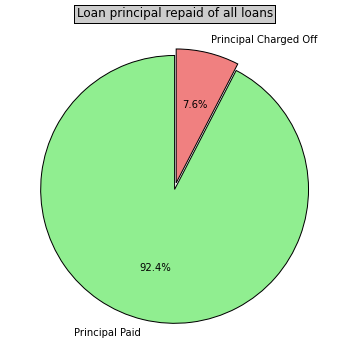

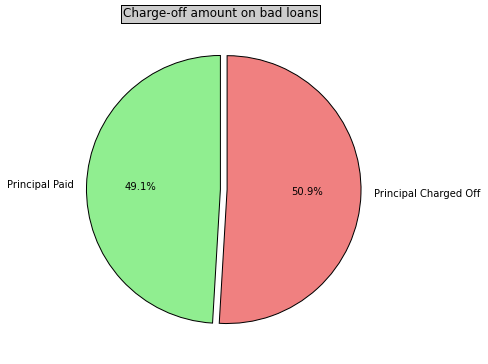

In [23]:
# Since we'll be looking at predicting loan performance, we'll limit the data set to only matured loans
as_of_date = max(df.last_pymnt_d)
df = df[df.maturity <= as_of_date]

# Add bad-loan to signify whether loan has taken charge-off
df["bad_loan"] = pd.Series(df.total_rec_prncp < df.funded_amnt)

df_fully_paid = df[df.bad_loan == False]
df_charged_off = df[df.bad_loan == True]

# First pie
plt.figure(0, figsize=(6,6))

labels = 'Fully Paid', 'Charged Off'
fracs = [len(df_fully_paid), 
         len(df_charged_off)]
explode=(0, 0.05)

plt.pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', colors = ['lightgreen','lightcoral'], startangle=90)

plt.title('Percentage of loans taking some charge-off', bbox={'facecolor':'0.8', 'pad':5})

print "%.2f%% of loans are taking some sort of charge off " % (len(df_charged_off) / len(df) * 100)

# Second pie
plt.figure(1, figsize=(6,6))

principal_paid = sum(df.total_rec_prncp)
principal_charged_off = sum(df.funded_amnt) - principal_paid

labels = 'Principal Paid', 'Principal Charged Off'
fracs = [principal_paid, 
         principal_charged_off]

plt.pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', colors = ['lightgreen','lightcoral'], startangle=90)

plt.title('Loan principal repaid of all loans', bbox={'facecolor':'0.8', 'pad':5})

print "%.2f%% of principal is not being repaid " % \
                        (principal_charged_off / (principal_paid + principal_charged_off) * 100)

# Third pie
plt.figure(2, figsize=(6,6))

principal_paid = sum(df_charged_off.total_rec_prncp) 
principal_charged_off = sum(df_charged_off.funded_amnt) - principal_paid

labels = 'Principal Paid', 'Principal Charged Off'
fracs = [principal_paid, 
         principal_charged_off]

plt.pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', colors = ['lightgreen','lightcoral'], startangle=90)

plt.title('Charge-off amount on bad loans', bbox={'facecolor':'0.8', 'pad':5})

print "Of those taking some kind of charge-off, the severity is %.2f%%" % \
                         (principal_charged_off / (principal_charged_off + principal_paid) * 100)

In [24]:
def stacked_bar_chart(stacks, title="", 
                      labels=None,     
                      colors = ['lightgreen','lightcoral', 'lightgoldenrodyellow','lavender','lightcyan']):
    """ Display pretty stacked bar chart
        
        Parameters
        ----------
        stacks: array-like
            list of values for the chart
        labels: array-like
            list of labels for the chart
        
        Returns
        ----------
        self: object
        """
    if labels is None:
        labels = ['' for i in range(len(stacks))]

    # plot
    fig, ax = plt.subplots(figsize=(18, 6))
    width = 0.8; 
    xlocations=np.array(range(len(stacks[0])+2))
    adjlocs = xlocations[1:-1] - width/2.0
    
    bar_heights = np.zeros(len(stacks[0]))
    for num in range(len(stacks)):
        bars = ax.bar(adjlocs, stacks[num], width, 
         label=labels[num], color=colors[num % len(colors)],
         bottom=sum(stacks[:num]))
        
        stack_labels = ["%.2f%% " % (val * 100) for val in stacks[num].tolist()]
        
        for rect, label, height in zip(bars.patches, stack_labels, bar_heights):
            ax.text(rect.get_x() + rect.get_width()/2, height, 
                    label, color='black', ha='center', va='bottom')
        bar_heights += np.array([bar.get_height() for bar in bars.patches])
        

    # pretty-up
    if max(map(lambda x: len(str(x)), stacks[0].index)) > 4:
        # rotate x label if large
        xrotation = 45
    else:
        xrotation = 0
        
    ax.set_xticks(ticks=xlocations[1:-1])
    ax.set_xticklabels(stacks[0].index, rotation=xrotation)
    ax.yaxis.grid(True)
    ax.legend(loc='best', prop={'size':'small'})
    fig.suptitle(title)
    fig.tight_layout(pad=2)
    


Severity averages at 46%


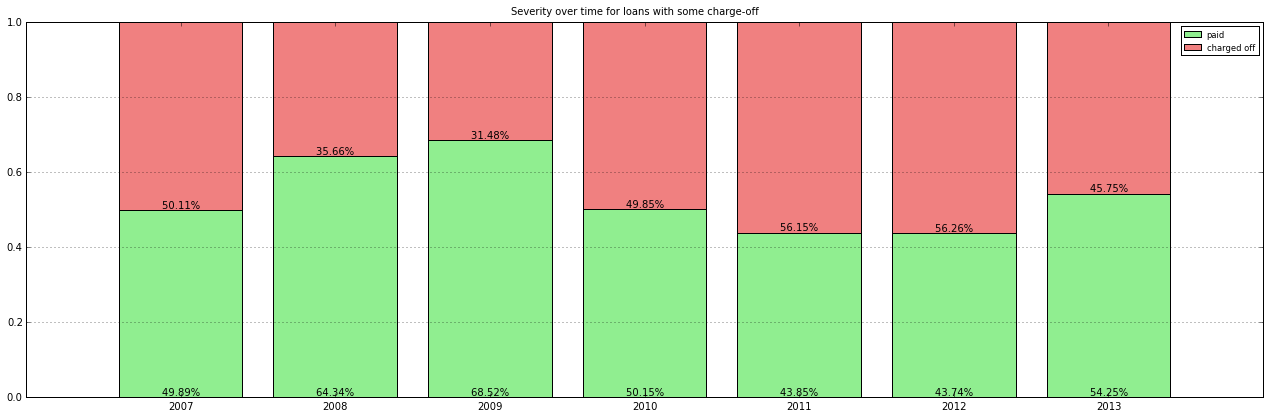

In [25]:
# Let's look at loan severity for those loans taking some kind of charge-off

charged_off_paid = df_charged_off.groupby(df_charged_off.issue_d.dt.year).total_rec_prncp.sum()
charged_off_funded = df_charged_off.groupby(df_charged_off.issue_d.dt.year).funded_amnt.sum()
paid = (charged_off_paid / charged_off_funded)
charged_off = 1 - paid

stacked_bar_chart([paid, charged_off], labels=['paid', 'charged off'],
                  title="Severity over time for loans with some charge-off")

print "Severity averages at %d%%" % (np.mean(charged_off) * 100)



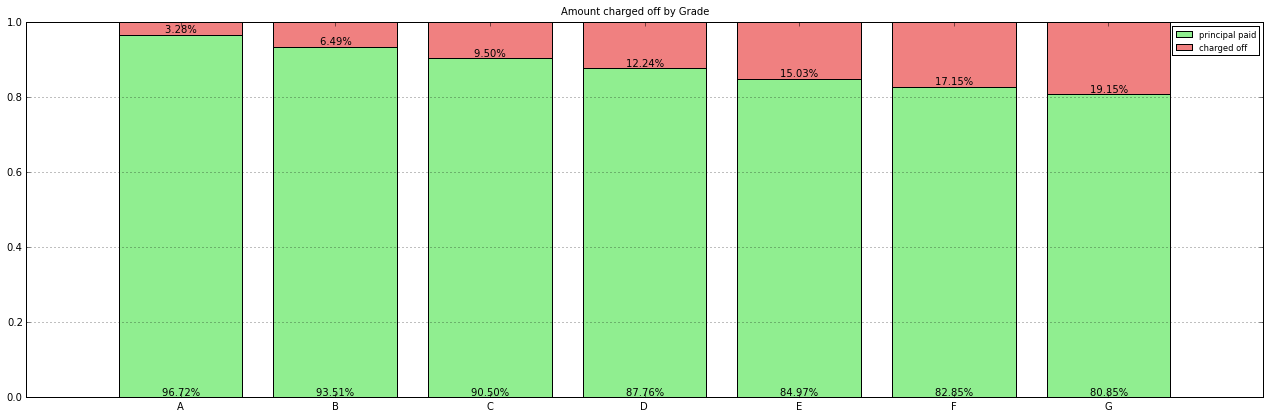

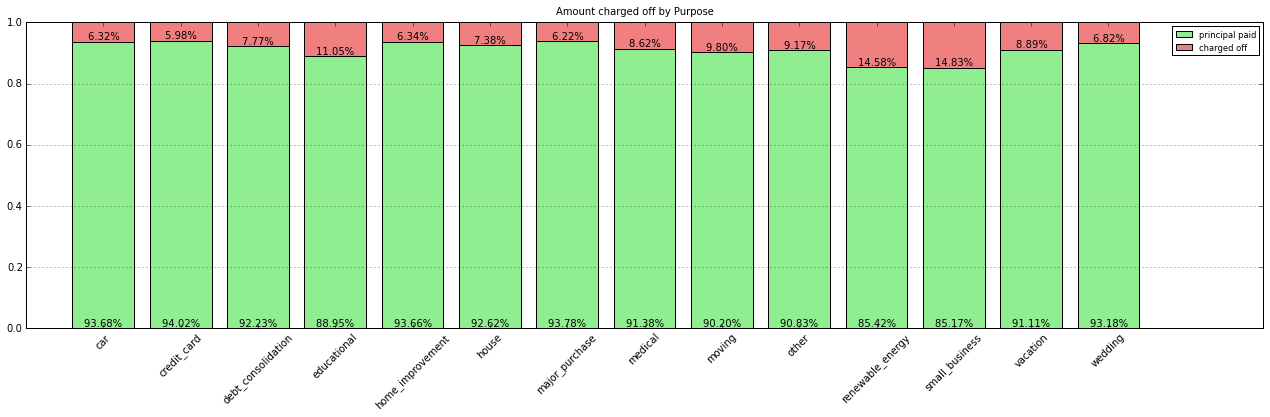

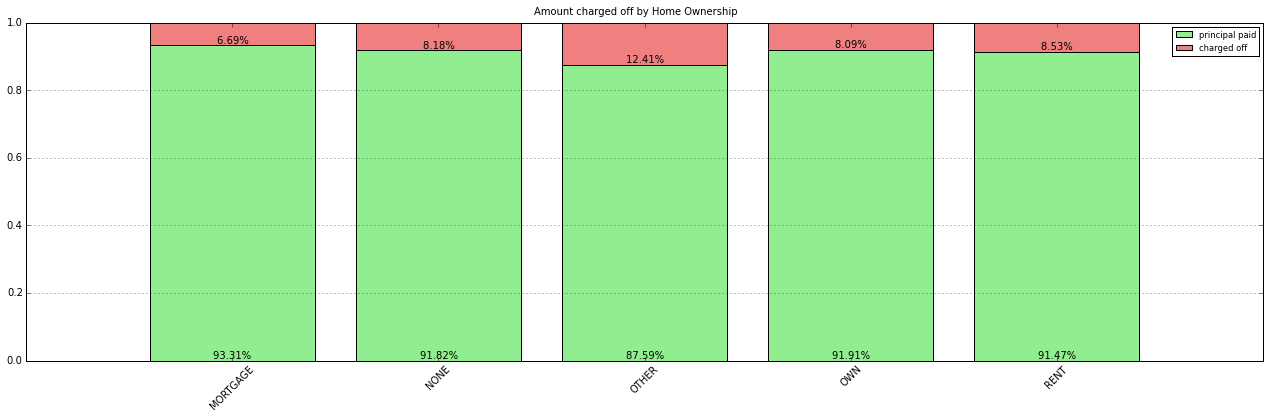

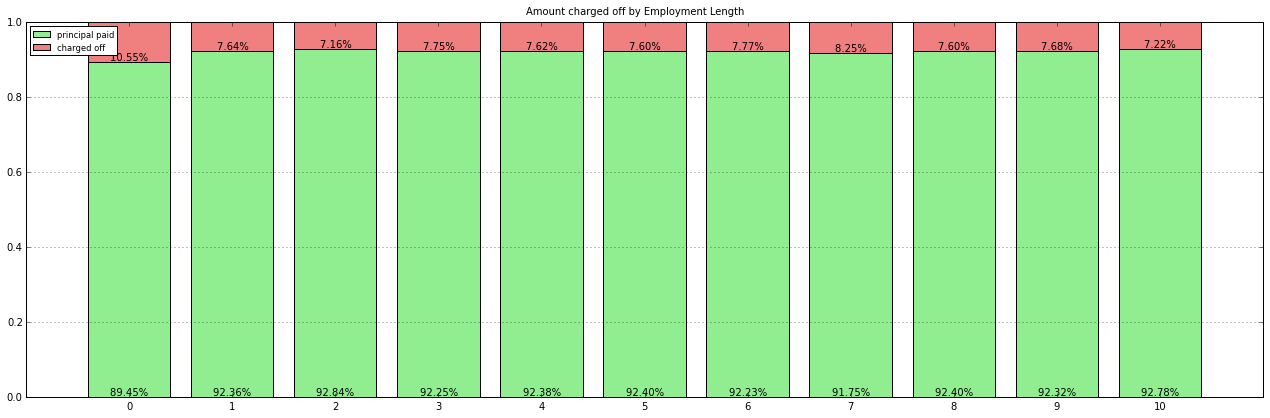

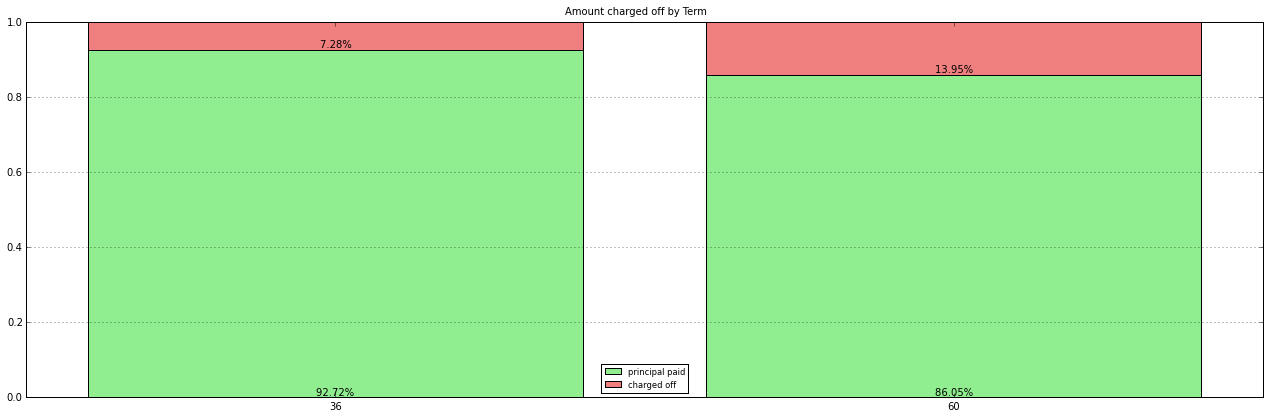

In [27]:
# Charge-offs based on type of loan

categorical_features = [df.grade, df.purpose, df.home_ownership, 
                        df.emp_length, df.term]
categorical_features_labels = ['Grade', 'Purpose', 'Home Ownership', "Employment Length", "Term"]

for feature, label in zip(categorical_features, categorical_features_labels):
    funded = df.groupby(feature).funded_amnt.sum()
    principal_paid = df.groupby(feature).total_rec_prncp.sum()
    interest_paid = df.groupby(feature).total_rec_int.sum()
    charged_off = funded - principal_paid

    principal_paid /= funded
    interest_paid /= funded
    charged_off /= funded

    stacked_bar_chart([principal_paid, charged_off], labels=['principal paid', 'charged off'],
                    title="Amount charged off by %s" % label)



In [29]:
# Calculating Returns

# Add total return
df['total_return'] = pd.Series((df.total_rec_prncp + 
                                        df.total_rec_int + 
                                        df.total_rec_late_fee) / df.funded_amnt - 1, index=df.index)

# Add number of payments made
df['num_payments_made'] = pd.Series(
    [max(1, mdiff(start,end)) for start, end in zip(df.issue_d, df.last_pymnt_d)], index=df.index)

# Add average payment
df['average_payment'] = pd.Series(
        ((df.total_rec_prncp + 
          df.total_rec_int + 
          df.total_rec_late_fee) / df.num_payments_made ), 
    index=df.index
)

# Monthly returns -- assuming equal monthly payments from issue date to last payment date
returns = np.array([np.rate(n, pmt, pv, 0) for n, pmt, pv in 
          zip(df.num_payments_made, df.average_payment, -df.funded_amnt)])

# Annualize returns (simple return, not compounding)
# Note that annualized returns don't really make sense with loans taking a loss
# For instance, if the loan only returns 50% over 2 years, the total return would be -0.5 and the annualized
returns = ( 1 + returns) ** 12 - 1
df['annual_return'] = pd.Series(returns, index=df.index)

Returns by group

Note that returns look in line with historical returns provided by Lending Club* although  our calculated returns are lower than that provided by Lending Club. This is likely because Lending Club reports Net Annualized Return which includes an estimate of future losses based off historical charge off rates by loan grade and loan status over a 9-month period. Our model just looks at matured loans. Even though the annual returns are different that those reported by Lending Club, the relative return amounts are the same with E loans giving the highest returns.

https://www.lendingclub.com/info/demand-and-credit-profile.action

In [30]:
df[['total_return','annual_return']].groupby([df.term,df.grade]).aggregate([np.mean, len])

total_return          annual_return         
                   mean      len          mean      len
term grade                                             
36   A         0.064402  22287.0      0.050210  22287.0
     B         0.092676  31126.0      0.068903  31126.0
     C         0.098021  18551.0      0.069233  18551.0
     D         0.106112   9735.0      0.069961   9735.0
     E         0.114698   1880.0      0.071129   1880.0
     F         0.098620    342.0      0.054135    342.0
     G         0.060875     80.0      0.013726     80.0
60   A         0.103020    279.0      0.044090    279.0
     B         0.111460   1070.0      0.031101   1070.0
     C         0.126565    817.0      0.015910    817.0
     D         0.168396    747.0      0.052536    747.0
     E         0.166323    693.0      0.041283    693.0
     F         0.211851    255.0      0.081807    255.0
     G         0.230359    104.0      0.075821    104.0

In [31]:
def print_return_results(loan):
    print "$%d borrowed @ %s interest" % (loan.iloc[0].funded_amnt, loan.iloc[0].int_rate)
    print "Issued on %s. Last payment on %s" % (loan.iloc[0].issue_d.strftime('%m/%d/%Y'), 
                                                loan.iloc[0].last_pymnt_d.strftime('%m/%d/%Y'))
    print "Number of payments made: %d" % (loan.iloc[0].num_payments_made) 
    print "For a total return of %s%% and annualized return of %s%%" % (loan.iloc[0].total_return * 100, 
                                                                      loan.iloc[0].annual_return * 100)
    print "# delinquincies: %d" % loan.iloc[0].delinq_2yrs

In [32]:
# Let's look at some outliers

# Note: Actual annualized return is higher than the interest rate charged due to delinquincies and 
# interest accruing on unpaid interest. This is seen by the number of delinquincies of this loan (3)
print "Best performing loan (annualized): "
best_annual_return = df[df.annual_return == df.annual_return.max()]
print_return_results(best_annual_return)
print "\n"

print "Best performing loan (total return): "
best_total_return = df[df.total_return == df.total_return.max()]
print_return_results(best_total_return)
print "\n"

print "Worst performing loan: "
worst_annual_return = df[df.annual_return == df.annual_return.min()]
print_return_results(worst_annual_return)
print "\n"

print "Longest loan: "
longest_loan = df[df.num_payments_made == df.num_payments_made.max()]
print_return_results(longest_loan)
print "\n"

Best performing loan (annualized): 
$24250 borrowed @ 24.89 interest
Issued on 07/01/2012. Last payment on 03/01/2013
Number of payments made: 8
For a total return of 15.4539793814% and annualized return of 47.7893536173%
# delinquincies: 3


Best performing loan (total return): 
$20000 borrowed @ 21.64 interest
Issued on 09/01/2010. Last payment on 10/01/2015
Number of payments made: 61
For a total return of 64.48595% and annualized return of 23.4936742456%
# delinquincies: 0


Worst performing loan: 
$1000 borrowed @ 14.65 interest
Issued on 12/01/2011. Last payment on 01/01/2012
Number of payments made: 1
For a total return of -96.558% and annualized return of -100.0%
# delinquincies: 0


Longest loan: 
$15000 borrowed @ 15.65 interest
Issued on 12/01/2009. Last payment on 10/01/2015
Number of payments made: 70
For a total return of 39.7160666674% and annualized return of 12.7398713215%
# delinquincies: 0




In [33]:
# Let's look at some of the 'bad loans' (loans which did not receive full principal)

bad_loans = df[df.bad_loan == True]
good_loans = df[df.bad_loan == False]

print "Highest total return bad loan: "
best_total_return_bad_loan = bad_loans[bad_loans.total_return == bad_loans.total_return.max()]
print_return_results(best_total_return_bad_loan)
print "\n"

print "Highest annual return bad loan: "
best_annual_return_bad_loan = bad_loans[bad_loans.annual_return == bad_loans.annual_return.max()]
print_return_results(best_annual_return_bad_loan)
print "\n"

Highest total return bad loan: 
$32000 borrowed @ 19.74 interest
Issued on 02/01/2011. Last payment on 02/01/2016
Number of payments made: 60
For a total return of 57.85475% and annualized return of 21.5407094267%
# delinquincies: 0


Highest annual return bad loan: 
$15000 borrowed @ 19.82 interest
Issued on 10/01/2009. Last payment on 12/01/2010
Number of payments made: 14
For a total return of 18.6588% and annualized return of 32.4248760312%
# delinquincies: 0




Somewhat surprisingly, the best performing 'bad loans' (loans which took some principal charge-off) actually had a high return despite not receiving full principal repayment. In fact, a large percentage of 'bad loans' had positive returns. Rather than predicting the likelihood a loan will take any kind of principal charge-off, we should try and predict the amount of expected principal charge-off. We can then try to maximize expected annualized return

In [34]:
print "%0.2f%% of 'bad loans' had positive return" % \
(len(bad_loans[bad_loans.total_return > 0]) / len(bad_loans) * 100.0)

df['chargeoff_pct'] = pd.Series( 1 - df.total_rec_prncp/df.funded_amnt, index=df.index)


20.11% of 'bad loans' had positive return


In [35]:
### Predicting Bad Loans ###

# The fields used for analysis should be limited to those that are available at time of origination
fields = ['grade','sub_grade', 'funded_amnt', 'int_rate', 'term', 'home_ownership', 'emp_length', 'dti', 'purpose',
 'credit_history','open_acc','total_acc','revol_bal','revol_util']

numeric_fields = [field for field in fields if df[field].dtype in [np.float, np.int] and field != 'term']
categorical_fields = [field for field in fields if field not in numeric_fields]

In [36]:
# Create dummy field for categorical data

df_train = df[numeric_fields].copy(deep=True)

for field in categorical_fields:
    dummy = pd.get_dummies(df[field], prefix=field).iloc[:, :]
    df_train = pd.concat([df_train, dummy], axis=1)

In [25]:
# We'll be trying to predict chargeoff percent since chargeoff is what will most adversly affect
# the total return. Based on the expected chargeoff and interest rate of the loan, we can approximate
# the expected return

X = df_train
X = X.fillna(X.mean())
y = df.chargeoff_pct

In [27]:
from sklearn import preprocessing

# standardize numerical fields
scaler = preprocessing.StandardScaler()
X[numeric_fields] = scaler.fit_transform(X[numeric_fields])

ImportError: cannot import name __check_build

In [621]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2,random_state=0)

In [223]:
def test(model_type, train_X, train_y, test_X, test_y,kwargs=None):
    if kwargs is not None:
        model = model_type(**kwargs)
    else:
        model = model_type()
    
    model.fit(train_X, train_y)
    train_mean_error = (model.predict(train_X) - train_y).mean()
    test_mean_error = (model.predict(test_X) - test_y).mean()
    
    return {'model': model,
            'name':model.__class__.__name__, 
            'kwargs':kwargs, 
            'train_mean_error': train_mean_error, 
            'test_mean_error':  test_mean_error,
            'score': model.score(test_X, test_y)
           }

In [484]:
from sklearn.base import BaseEstimator,RegressorMixin

# This is our own custom prediction model that just takes the average value of the training data
# grouped by given field

class GroupByEstimator(BaseEstimator,RegressorMixin):
    """Predicts the majority class of its training data.""" 
    def __init__(self, groupby_prefix=None,func=np.mean):
        self.groupby_prefix_ = groupby_prefix
        self.group_coef_ = {}
        self.intercept_ = None
        self.func_ = func

    def fit(self, X, y):
        self.intercept_ = self.func_(y)
        if self.groupby_prefix_:
            groups = [group for group in X.columns.tolist() if self.groupby_prefix_ in group]
            for group in groups:
                self.group_coef_[group] = self.intercept_ - self.func_(y[X[group] == True])
        return self

    def predict(self, X):
        predictions = np.array(np.repeat(self.intercept_, len(X)))
        for group, val in self.group_coef_.iteritems():
            predictions[np.where(X[group])] += val
        return predictions


In [622]:
models = []

# predict average charge-off for every loan
models.append(test(GroupByEstimator, train_X, train_y, test_X, test_y))

# predict median charge-off for every loan (no charge-off since median charge-off amount is 0)
models.append(test(GroupByEstimator, train_X, train_y, test_X, test_y, kwargs={'func':np.median}))

# predict average charge-off for every loan grouped by various categorical fields
for prefix in categorical_fields:
    models.append(test(GroupByEstimator, train_X, train_y, test_X, test_y, kwargs={'groupby_prefix': prefix}))

# linear regression
models.append(test(linear_model.LinearRegression, train_X, train_y, test_X, test_y))

# linear regression with normalization
models.append(test(linear_model.LinearRegression, train_X, train_y, test_X, test_y,kwargs={'normalize':True}))

# ridge regression with various alpha values
models.append(test(linear_model.Ridge, train_X, train_y, test_X, test_y, kwargs={'alpha':0.25}))
models.append(test(linear_model.Ridge, train_X, train_y, test_X, test_y, kwargs={'alpha':0.5}))
models.append(test(linear_model.Ridge, train_X, train_y, test_X, test_y, kwargs={'alpha':0.75}))

# decision tree regressor
models.append(test(tree.DecisionTreeRegressor, train_X, train_y, test_X, test_y))

# lasso method
models.append(test(linear_model.Lasso, train_X, train_y, test_X, test_y, kwargs={'alpha':0.5}))

# elastic net
models.append(test(linear_model.ElasticNet, train_X, train_y, test_X, test_y))

In [623]:
est_chargeoffs = []
est_chargeoff_col_names = []
# add predicted charge-off amounts to dataframe
for model in models:
    col_name = 'est_chargeoff_' + model['name']
    if model['kwargs'] is not None:
        for k,v in model['kwargs'].iteritems():
            col_name += '_' + k + '_' + str(v)
    est_chargeoff_col_names += [col_name]
    est_chargeoff = pd.Series(model['model'].predict(test_X), index=test_X.index, name=col_name)
    est_chargeoffs += [est_chargeoff]

In [624]:
est_return_col_names = [col_name.replace('chargeoff','return') for col_name in est_chargeoff_col_names]
df_test = df[df.index.isin(est_chargeoffs[0].index)].join(pd.DataFrame(est_chargeoffs).T)

for chargeoff_col_name, return_col_name in zip(est_chargeoff_col_names, est_return_col_names):
    df_test[return_col_name] = df_test.int_rate/100 - (df_test[chargeoff_col_name] / (df_test.term / 12))

In [625]:
def get_performance(df, selection_col, results_col):
    df = df.sort_values(by=[selection_col], ascending=[False])
    return pd.Series([df[[results_col]][:N].mean() for N in range(len(df_test))], index=df.index)

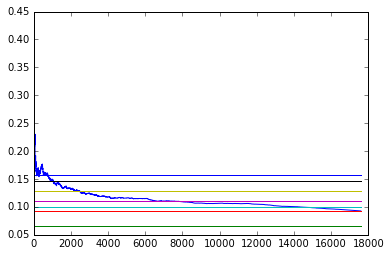

In [627]:
plt.plot(range(1,len(df_test)+1), get_performance(df_test, 'est_return_ElasticNet', 'total_return'))

returns_by_grade = df.total_return.groupby(by=df.grade).mean()
for returns in returns_by_grade:
    plt.plot([0,len(df_test)+1],[returns,returns])
plt.ylabel=["Number of Loans"]
plt.xlabel=["Return"]
plt.title="ElasticNet"

In [561]:
returns_by_grade = df.total_return.groupby(by=df.grade).mean()
for returns in returns_by_grade:
    print returns
    
#     plt.plot([0,len(df_test)+1],[returns,returns],label=)
print returns_by_grade
plt.ylabel=["Number of Loans"]
plt.xlabel=["Return"]
plt.title="ElasticNet"

# plt.plot([3,4,5], [1,8, 26])
# plt.plot([0,5], [20,20])
# df.total_return.groupby(by=df.grade).mean()
# plt.plot(range(1,len(df_test+1)),df_test[df_test.grade == 'A'].total_return.mean())

0.0648796048397
0.0933002423046
0.0992253067613
0.110550867227
0.128602442796
0.146984964344
0.156670081523
grade
A    0.064880
B    0.093300
C    0.099225
D    0.110551
E    0.128602
F    0.146985
G    0.156670
Name: total_return, dtype: float64
